# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import os,glob
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d,griddata
from matplotlib.colors import LogNorm
import pyslha
from scipy.interpolate import interp1d,LinearNDInterpolator,NearestNDInterpolator


delphesDir = os.path.abspath("./MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')


pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

Welcome to JupyROOT 6.24/06


In [2]:
def getModelDict(inputFile):

    
    modelInfoDict = {}
    f = inputFile
    if not os.path.isfile(f):
        print('File %s not found' %f)
        raise OSError()
    parsDict = {}    
    for banner in glob.glob(os.path.join(os.path.dirname(f),'*banner*txt')):
        with open(banner,'r') as ff:
            slhaData = ff.read().split('<slha>')[1].split('</slha>')[0]
            slhaData = pyslha.readSLHA(slhaData)
    parsDict = {}
    parsDict['mMed'] = slhaData.blocks['MASS'][55]
    parsDict['width'] = slhaData.decays[55].totalwidth
    parsDict['gq'] = slhaData.blocks['DMINPUTS'][4]

    modelInfoDict.update(parsDict)

    return modelInfoDict

In [3]:
def interpolateData(x,y,z,nx=200,ny=200,method='linear',fill_value=np.nan,xnew=None,ynew=None):

    if x.min() == x.max() or y.min() == y.max(): # Can not interpolate
        return None,None,None
    elif xnew is None or ynew is None:
        xnew = np.linspace(x.min(),x.max(),nx)
        ynew = np.linspace(y.min(),y.max(),ny)

    xi = np.array([list(v) for v in itertools.product(xnew,ynew)])
    znew = griddata(list(zip(x,y)),z,xi=xi, 
                    method=method,fill_value=fill_value)
    znew = np.reshape(znew,(len(xnew),len(ynew)))
    xnew,ynew  = np.meshgrid(xnew,ynew,indexing='ij')

    return xnew,ynew,znew



### Load Recast Data

In [21]:
inputFiles = glob.glob('./DMSimp_vector_dijet_tests2/Events/run_05/*.root')
inputDict = {}
for f in inputFiles:
    mDict = getModelDict(f)
    mMed,wMed,gq = mDict['mMed'],mDict['width'],mDict['gq']
    inputDict[(mMed,wMed,gq)] = f
inputDict = dict(sorted(inputDict.items()))

In [22]:
xsec = {}
br = {}
acc = {}

for (mMed,wMed,gq),inputFile in inputDict.items():
    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    npass = 0
    n_acc = 0
    total_xsec = 0.0
    for ievt in range(nevts):
        tree.GetEntry(ievt)
        weightPB = tree.Weight.At(1).Weight
        total_xsec += weightPB
        daughters = []
        for iptc in range(tree.Particle.GetEntries()):
#             if iptc > 100:
#                 break
            p = tree.Particle.At(iptc)            
#             print(iptc,':',p.PID,'->',p.D1,p.D2)
            if p.Status == 23:
                daughters.append(p)    
                                                      
        if len(daughters) != 2:
            print('More than one mediator found in event',ievt)
            break

        if any(abs(d.PID) in [6,52] for d in daughters):
            continue
            
        npass += 1
        dEta = abs(daughters[0].Eta-daughters[1].Eta)
        if dEta > 1.1:
            continue
        if any(abs(d.Eta) > 2.5 for d in daughters):
            continue
        n_acc += 1
        

    print('Mass = %1.0f' %mMed, 'Width = %1.2e' %wMed, 'Acceptance = %1.2f' %(float(n_acc)/npass))
    print('BR = ',float(npass)/nevts)
    print('Total xsec (pb) = %1.3e' %total_xsec)
    print('sigma*BR*Acc = %1.3e' %(total_xsec*n_acc/nevts))
    print()
    xsec[(mMed,wMed,gq)] = total_xsec
    br[(mMed,wMed,gq)] = float(npass)/nevts
    acc[(mMed,wMed,gq)] = float(n_acc)/npass
    f.Close()
            

Mass = 4500 Width = 8.93e+02 Acceptance = 0.38
BR =  1.0
Total xsec (pb) = 7.427e-02
sigma*BR*Acc = 2.818e-02



### ATLAS values

In [6]:
dataPts = []
allw = set([])
with open('./HEPData-ins1764471-v1-Cross-section_limits_for_a_qq,_spin_1_dijet_resonance.csv','r') as f:
    data = f.read()
    blocks = data.split('Resonance mass')[1:]
    for b in blocks:
        lines = b.split('\n')
        header = lines[0]
        width = header.split(',')[-1]
        width = width.strip()
        width = width.split()[0]
        width = eval(width.replace('%','*1e-2'))
        allw.add(width)
        for l in lines[1:]:
            if not l.strip():
                continue
#             print(l)
            try:
                mass = eval(l.split(',')[0])
                xsecUL = eval(l.split(',')[1])
                w = mass*width
                dataPts.append([mass,w,xsecUL])
            except:
                pass

print(allw)            

{0.1, 0.55, 0.01, 0.3}


In [7]:
excCurve = np.genfromtxt('HEPData-ins1764471-v1-Coupling_limits_DM_mediator.csv',delimiter=',',skip_header=80)

In [8]:
dataPts = np.array(dataPts)

In [9]:
xsecUL_F = LinearNDInterpolator((dataPts[:,0],dataPts[:,1]),dataPts[:,2],fill_value=0.0)


In [10]:
pts = []
for (m,w,gq) in xsec:
    s = xsec[(m,w,gq)]*br[(m,w,gq)]*acc[(m,w,gq)]
    r = 1.2*s/xsecUL_F(m,w)
    pts.append([m,gq,r])
    print('m = %1.0f' %m,'gq = %1.2f' %gq,'(%1.2f %%)' %(1e2*w/m))
    print(3*'%1.3f ' %(s,xsecUL_F(m,w),r))
    print()

m = 4500 gq = 0.60 (19.84 %)
0.028 0.047 0.726 



In [11]:
pts = np.array(pts)

TypeError: Input z must be 2D, not 0D

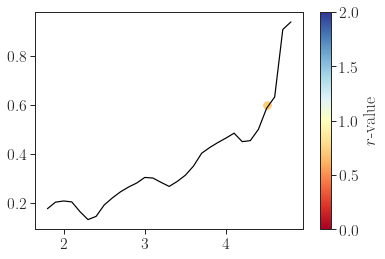

In [12]:
cm = plt.colormaps['RdYlBu']
plt.scatter(pts[:,0]/1e3,pts[:,1],c=pts[:,2],cmap=cm,s=60,vmin=0.,vmax=2.0)
plt.plot(excCurve[:,0]/1e3,excCurve[:,1],label='ATLAS',c='black')

x = pts[:,0]/1e3
y = pts[:,1]
rValues = pts[:,2]
xnew,ynew,znew = interpolateData(x,y,rValues,nx=300,ny=300)
cValues = sorted([1.])
# Get contours
plt.colorbar(label=r'$r$-value')
contours = plt.contour(xnew, ynew, znew, cValues, 
                       colors='red',linestyles=['dashed','solid'],linewidths=2.0)
plt.xticks(np.arange(2.,5.5,0.5))
plt.yticks(np.arange(0.1,0.9,0.1))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()